#  HEP-Th Runtime experiments

In this notebook we measure the runtime of forward, backward, and inference computations for graph edit networks (without edge filtering, with edge filtering, and with a constant number of maximum edge-edited nodes) on realistic graphs from the HEP-Th dataset.

In [4]:
from tqdm import tqdm

In [25]:
import time
import numpy as np
import torch
import pytorch_graph_edit_networks as gen
import hep_th

# model parameters
num_layers = 3
dim_hid = 64
nonlin = torch.nn.Tanh()

# initialize model, one without edge filters, one with edge filters, but no limit, and one
# with limit
filter_options = [True, 538]
# set up model names for result storage
model_names = ['flex_filter', 'const_filter']
comp_names  = ['forward', 'backward']
headers = ['sizes']
for model_name in model_names:
    for comp_name in comp_names:
        headers.append('%s_%s' % (model_name, comp_name))

max_past = 12


# set up a list of all experimental settings
month_tuples = []
for year in range(1992,2003+1):
    max_month = 12
    if year == 2003:
        max_month = 4
    for month in range(1, max_month+1):
        month_tuples.append((year, month))
settings = []
for past in range(1, max_past+1):
    for t in range(past, len(month_tuples)):
        settings.append((month_tuples[t][0], month_tuples[t][1], past))


In [28]:
# check which models still need to be processed
import os
for repetition in range(1,5):
    print(f'****** new rep!!! {repetition}/4')
# try to load prior runtime results from disk

    if os.path.exists(f'hep_th_runtimes_{repetition}.csv'):
        data     = np.loadtxt(f'hep_th_runtimes_{repetition}.csv', delimiter='\t', skiprows = 1)
        sizes    = data[:, 0]
        Runtimes = data[:, 1:].T
    else:
        Runtimes = np.zeros((len(filter_options) * 3, len(settings)))
        # compute graph sizes
        sizes = np.zeros(len(settings))
        s = 0
        for past in range(1, max_past+1):
            for t in range(past, len(month_tuples)):
                past_months = month_tuples[(t-past):t]
                A, I = hep_th.read_graph_from_csv('hep-th/graphs/%d_%d.csv' % (past_months[0][0], past_months[0][1]))
                for past_month in past_months[1:]:
                    # parse the current graph from CSV data
                    B, J = hep_th.read_graph_from_csv('hep-th/graphs/%d_%d.csv' % (past_month[0], past_month[1]))
                    # add B, J to A, I
                    A, I = hep_th.add_graph(A, I, B, J)
                sizes[s] = len(I)
                s += 1

    remaining_models = []
    for model_idx in range(len(filter_options)):
        if np.any(Runtimes[model_idx*2:(model_idx+1)*2, :] < 1E-8):
            remaining_models.append(model_idx)
    # iterate over all models
    for model_idx in remaining_models:
        print('processing edge filter option %s' % str(filter_options[model_idx]))
        # check all remaining experimental settings
        remaining_settings = np.where(np.any(Runtimes[model_idx*2:(model_idx+1)*2, :] < 1E-8, 0))[0]
        # iterate over all possible experimental settings
        last_past = -1
        for s in remaining_settings:
            year, month, past = settings[s]
            if past != last_past:
                if last_past > 0:
                    print('required a total time of %g seconds' % np.sum(Runtimes[(model_idx*2):(model_idx*2+2), last_s:s]))
                print('considering %d past months for graph construction' % past)
                last_past = past
                last_s = s
            # initialize a new network
            net = gen.GEN(num_layers = num_layers, dim_in = 1, dim_hid = dim_hid, nonlin = nonlin, filter_edge_edits = filter_options[model_idx])
            # compute a forward pass for loss computation
            start_time = time.time()
            loss = hep_th.compute_loss(net, year, month, past = past)
            #print(loss)
            Runtimes[model_idx * 2 + 0, s] = time.time() - start_time
            # compute gradient
            start_time = time.time()
            loss.backward()
            Runtimes[model_idx * 2 + 1, s] = time.time() - start_time
            # switch to eval mode and do another forward pass
            #net.eval()
            #start_time = time.time()
            #loss = hep_th.compute_loss(net, year, month, past = past)
            #Runtimes[model_idx * 3 + 2, s] = time.time() - start_time
            # store results
            np.savetxt(f'hep_th_runtimes_{repetition}.csv', np.concatenate((np.expand_dims(sizes, 1), Runtimes.T), 1), delimiter='\t', header='\t'.join(headers), fmt='%g', comments = '')

****** new rep!!! 1/4
processing edge filter option True
considering 1 past months for graph construction
required a total time of 14.7095 seconds
considering 2 past months for graph construction
required a total time of 14.284 seconds
considering 3 past months for graph construction
required a total time of 27.8696 seconds
considering 4 past months for graph construction
required a total time of 41.787 seconds
considering 5 past months for graph construction
required a total time of 53.2917 seconds
considering 6 past months for graph construction
required a total time of 63.9914 seconds
considering 7 past months for graph construction
required a total time of 73.891 seconds
considering 8 past months for graph construction
required a total time of 81.6504 seconds
considering 9 past months for graph construction
required a total time of 93.0102 seconds
considering 10 past months for graph construction
required a total time of 98.9877 seconds
considering 11 past months for graph construc

In [ ]:
print('this is the new version')

log-fit for forward computation of flex_filter model: log(y) = 1.34894 * log(x) + -10.6106
log-fit for forward computation of const_filter model: log(y) = 1.30151 * log(x) + -10.0787
log-fit for backward computation of flex_filter model: log(y) = 1.31532 * log(x) + -13.9292
log-fit for backward computation of const_filter model: log(y) = 1.78028 * log(x) + -15.3072


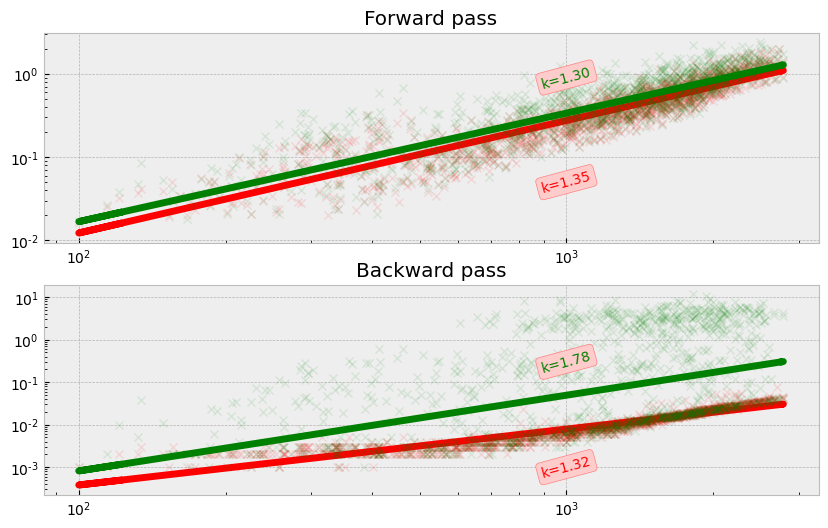

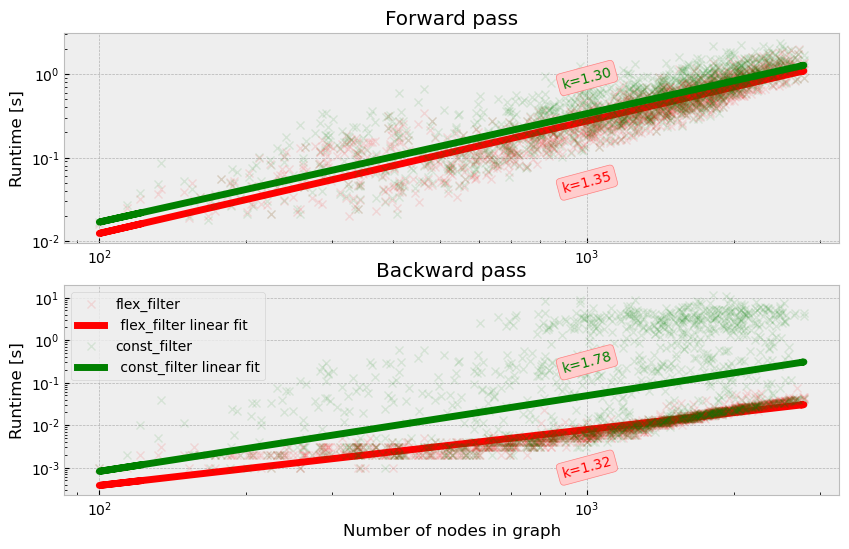

In [24]:
# load results again
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
plt.style.use('bmh')
data     = np.loadtxt('hep_th_runtimes_5.csv', delimiter='\t', skiprows = 1)
sizes    = data[:, 0]
Runtimes = data[:, 1:].T

model_names = ['flex_filter', 'const_filter']
colors = 'rgb'
comp_names  = ['forward', 'backward']
titles = ['Forward pass', 'Backward pass']
pos = [(0.05, 0.9,), (0.001, 0.3,)]
cs = ('red', 'green', 'blue')
rot = [[15., 15., 65.], [15., 15., 35.]]
fig, axx = plt.subplots(2,1, figsize=(10,6))
for c in range(len(comp_names)):
    ax = axx[c]
    for model_idx in range(len(model_names)):
        # perform a log-log linear fit
        y = Runtimes[model_idx * 3 + c, :]
        x = sizes[y > 1E-8]
        y = y[y > 1E-8]
        w, b, _, _, _ = linregress(np.log(x), np.log(y))
        print('log-fit for %s computation of %s model: log(y) = %g * log(x) + %g' % (comp_names[c], model_names[model_idx], w, b))
        # plot the data and the log fit
        ax.loglog(x, y, colors[model_idx] + 'x', alpha=0.1)
        ax.loglog(x, np.power(x, w) * np.exp(b), colors[model_idx] + '-', linewidth=5)
        ax.set_title(titles[c])
        ax.text(1000, pos[c][model_idx], f"k={w:.2f}", size=10, rotation=rot[c][model_idx], color=cs[model_idx],
                 ha="center", va="center",
                 bbox=dict(boxstyle="round",
                           ec=(1., 0.5, 0.5),
                           fc=(1., 0.8, 0.8),
                           facecolor='wheat',
                           )
                 )

legend_strings = []
for model_idx in range(len(model_names)):
    legend_strings.append(model_names[model_idx])
    legend_strings.append(f' {model_names[model_idx]} linear fit')

axx[1].set_xlabel('Number of nodes in graph')
axx[0].set_ylabel('Runtime [s]')
axx[1].set_ylabel('Runtime [s]')
plt.legend(legend_strings)
fig = plt.gcf()
plt.rcParams['savefig.facecolor']='white'
#fig.set_size_inches(13, 10)
plt.savefig('results/arXiv3.png')
plt.show()

In [21]:
data

array([[1.21000e+02, 3.20418e-02, 2.00248e-03, ..., 3.80039e-02,
        9.99570e-03, 3.60019e-02],
       [1.14000e+02, 2.49999e-02, 1.00017e-03, ..., 2.70000e-02,
        2.00152e-03, 2.69959e-02],
       [1.32000e+02, 3.69999e-02, 1.99771e-03, ..., 4.79968e-02,
        5.00154e-03, 4.70016e-02],
       ...,
       [2.78100e+03, 9.11019e-01, 4.49855e-02, ..., 8.98000e-01,
        4.10006e-02, 8.91048e-01],
       [2.76800e+03, 1.36500e+00, 4.49998e-02, ..., 1.29917e+00,
        4.20010e-02, 1.31304e+00],
       [2.78300e+03, 1.35400e+00, 4.30031e-02, ..., 1.71906e+00,
        4.26017e+00, 1.68204e+00]])